In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
import os
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if USE_CUDA else "cpu")
print(DEVICE)

cuda:0


In [3]:
#압축 해제 Code
'''import zipfile
import os

# 압축 파일과 압축 해제 경로
zip_file_path = 'CAPTCHA_IMAGES.zip'
extract_to = 'CAPTCHA_IMAGES'

# 폴더가 존재하지 않으면 생성
os.makedirs(extract_to, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"'{zip_file_path}' 파일이 '{extract_to}' 폴더에 성공적으로 압축 해제되었습니다.")'''

'CAPTCHA_IMAGES.zip' 파일이 'CAPTCHA_IMAGES' 폴더에 성공적으로 압축 해제되었습니다.


In [11]:
import splitfolders
splitfolders.ratio("CAPTCHA_IMAGES", output="CAPTCHA_IMAGES_SPLIT", seed=1004, ratio=(1, 0))

Copying files: 4068 files [00:14, 271.60 files/s]


In [4]:
classes = os.listdir("CAPTCHA_IMAGES")
print(classes)

['motorcycle', 'seaplane', 'boat', 'motorbus', 'bicycle', 'train', 'truck', 'airplane']


In [12]:
labels = os.listdir("CAPTCHA_IMAGES_SPLIT/train")
print(labels)

['motorcycle', 'seaplane', 'boat', 'motorbus', 'bicycle', 'train', 'truck', 'airplane']


In [13]:
import pandas as pd

names=[]
num_train=[]
num_test=[]
num_total = []

for name in labels:
    image_number_train = len(os.listdir(f"CAPTCHA_IMAGES_SPLIT/train/{name}"))
    image_number_test = len(os.listdir(f"CAPTCHA_IMAGES_SPLIT/val/{name}"))
    
    names.append(name)
    num_train.append(image_number_train)
    num_test.append(image_number_test)
    num_total.append(image_number_train+image_number_test)
dic = {'Label': names, 'Number(training)': num_train, 'Number(testing)': num_test, 'Total': num_total} 
    
df = pd.DataFrame(dic)
df

,Label,Number(training),Number(testing),Total
0,motorcycle,733,0,733
1,seaplane,355,0,355
2,boat,662,0,662
3,motorbus,317,0,317
4,bicycle,375,0,375
5,train,304,0,304
6,truck,819,0,819
7,airplane,503,0,503


In [14]:
print(f"Total training images: {df['Number(training)'].sum()}")
print(f"Total testing images: {df['Number(testing)'].sum()}")

Total training images: 4068
Total testing images: 0


img.shape  (128, 128, 3)
height  128
width  128
channel  3


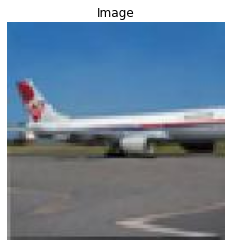

In [15]:
##Data information
#Height : 128
#Weight : 128
#Channel : 3

import numpy as np
import cv2


img = cv2.imread('CAPTCHA_IMAGES_SPLIT/train/airplane/1650199961986_0.jpg', cv2.IMREAD_COLOR)

print('img.shape ', img.shape)


h, w, c = img.shape

print('height ', h)
print('width ', w)
print('channel ', c)

# OpenCV는 BGR 포맷을 사용하므로 RGB로 변환
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# matplotlib를 이용해 이미지 표시
plt.imshow(img_rgb)
plt.title('Image')  # 이미지 제목 설정
plt.axis('off')  # 축 제거
plt.show()

In [16]:
class CUB_CAPTCHA(Dataset):
    def __init__(self, transform, mode='train', target_class = 'airplane'):
        self.transform = transform
        self.mode = mode
        base_path = 'CAPTCHA_IMAGES_SPLIT'  # 기본 경로 설정

        if self.mode == 'train':
            folder_path = os.path.join(base_path, 'train')
        elif self.mode == 'valid':
            folder_path = os.path.join(base_path, 'val')
        
        
        # 모든 하위 폴더의 파일을 포함
        self.image_paths = []
        self.labels = []

        for class_name in os.listdir(folder_path):
            if class_name not in target_class:
                continue
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    if os.path.isfile(img_path):  # 파일만 추가
                        self.image_paths.append(img_path)
                        self.labels.append(class_name)  # 클래스명으로 라벨 설정

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        # 라벨을 클래스 이름에서 추출
        label = self.labels[idx]

        # 문자열 라벨을 숫자로 매핑
        label_map = {  # 클래스 이름을 정수로 매핑
            'motorcycle': 0, 'seaplane': 1, 'boat': 2, 'motorbus': 3,
            'bicycle': 4, 'train': 5, 'truck': 6, 'airplane': 7
        }
        label = label_map[label]

        return img, label


In [17]:
# 데이터 변환 정의
'''transforms_train = transforms.Compose([
    transforms.Resize((448, 448)),              # 크기 조정
    transforms.RandomRotation(15),              # 무작위 회전
    transforms.RandomResizedCrop(448, scale=(0.8, 1.0)),  # 무작위 크롭
    transforms.RandomHorizontalFlip(p=0.5),     # 좌우 반전
    transforms.ToTensor(),                      # 텐서 변환
])'''

transforms_augmentation = transforms.Compose([
    transforms.Resize((64, 64)),              # 크기 조정
    transforms.RandomRotation(15),              # 무작위 회전
    transforms.RandomHorizontalFlip(p=0.5),     # 좌우 반전
    transforms.ToTensor(),                      # 텐서 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 픽셀 값을 [-1, 1]로 정규화
])

transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),              # 크기 조정
    transforms.ToTensor(),                      # 텐서 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 픽셀 값을 [-1, 1]로 정규화
])

In [22]:
'''BATCH_SIZE = 32

train_set = CUB_CAPTCHA(mode='train', transform=transforms_train) 
augmentation_set = CUB_CAPTCHA(mode='train', transform=transforms_augmentation)

CAPTCHA_train_set = ConcatDataset([train_set, augmentation_set])

train_loader = DataLoader(CAPTCHA_train_set, batch_size=BATCH_SIZE, shuffle=True)

print('Num of each dataset:', len(train_set), len(augmentation_set), len(CAPTCHA_train_set))
print("Loaded combined dataloader")'''

Num of each dataset: 503 503 1006
Loaded combined dataloader


In [18]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 여러 샘플 이미지와 라벨 시각화 함수
def show_samples_from_loader(loader, num_samples=10, cols=5):
    rows = (num_samples + cols - 1) // cols  # 필요한 행 계산
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    # 첫 번째 배치에서 데이터 가져오기
    data_iter = iter(loader)
    images, labels = next(data_iter)  # 배치에서 이미지와 라벨 가져오기

    for i in range(num_samples):
        if i >= len(images):  # 배치 크기를 초과하면 종료
            break

        # 이미지를 0-1 범위로 변환 후 PIL 이미지로 변환
        img = to_pil_image(0.5 * images[i] + 0.5)  # Normalize 해제 (if normalized)

        # 현재 subplot에 이미지 표시
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')  # 축 제거

    # 남은 빈 공간 subplot 제거
    for j in range(num_samples, rows * cols):
        if rows > 1:
            axes[j // cols, j % cols].axis('off')
        else:
            axes[j % cols].axis('off')

    plt.tight_layout()
    plt.show()

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.gan = nn.Sequential(
            nn.ConvTranspose2d(noise_size,512, kernel_size=4, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512 ,256, kernel_size=4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256,128, kernel_size=4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128,64, kernel_size=4, stride = 2, padding = 1,bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64,3,kernel_size = 4, stride = 2, padding = 1, bias = False),
            
            nn.Tanh()
        )

    def forward(self, x):
        return self.gan(x)

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
      
        # 감별자를 구성하는 층의 정의
        self.disc = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(64),
           nn.LeakyReLU(0.2),

           nn.Conv2d(64, 128, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(128),
           nn.LeakyReLU(0.2),

           nn.Conv2d(128, 256, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(256),
           nn.LeakyReLU(0.2),

           nn.Conv2d(256, 512, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(512),
           nn.LeakyReLU(0.2),

           nn.Conv2d(512, 1, kernel_size=4),
           nn.Sigmoid()
       )

    def forward(self, x):
        return self.disc(x)

In [21]:
def weights_init(m):
    # 층의 종류 추출
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # 합성곱층 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # 배치정규화층 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [25]:
def make_synthesize_img(label):
    base_dir = "CAPTCHA_DCGAN"  
    save_path = os.path.join(base_dir, label)  
    os.makedirs(save_path, exist_ok=True) 
    return save_path


In [26]:
def make_dataset(target_class):
    BATCH_SIZE = 32

    train_set = CUB_CAPTCHA(mode='train', transform=transforms_train, target_class = target_class) 
    augmentation_set = CUB_CAPTCHA(mode='train', transform=transforms_augmentation, target_class = target_class)

    CAPTCHA_train_set = ConcatDataset([train_set, augmentation_set])

    train_loader = DataLoader(CAPTCHA_train_set, batch_size=BATCH_SIZE, shuffle=True)

    print('Num of each dataset:', len(train_set), len(augmentation_set), len(CAPTCHA_train_set))
    print("Loaded combined dataloader")
    
    return train_loader

Num of each dataset: 733 733 1466
Loaded combined dataloader


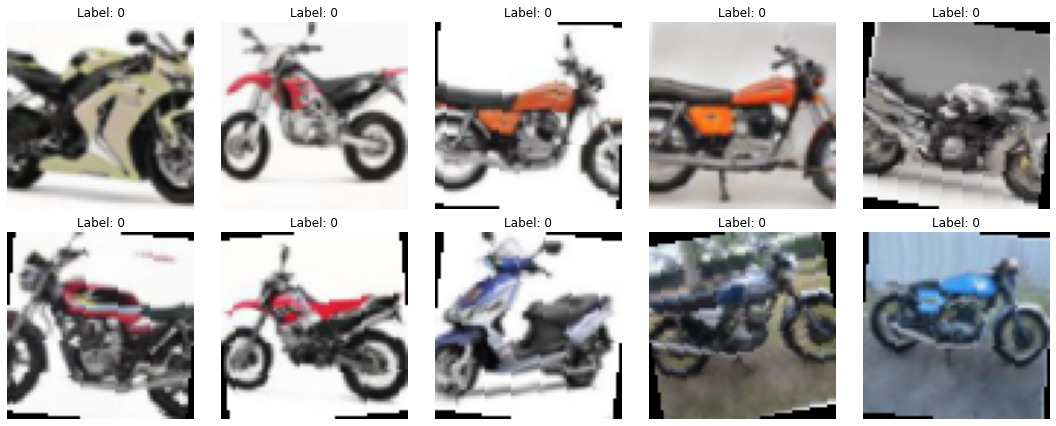

[Epoch 1/200] [Batch 0/46] [D loss: 0.6558] [G loss: 3.3277]
[Epoch 1/200] [Batch 32/46] [D loss: 0.0122] [G loss: 10.3874]
[Epoch 2/200] [Batch 0/46] [D loss: 0.1160] [G loss: 15.4524]
[Epoch 2/200] [Batch 32/46] [D loss: 0.0497] [G loss: 7.5626]
[Epoch 3/200] [Batch 0/46] [D loss: 0.0203] [G loss: 7.5076]
[Epoch 3/200] [Batch 32/46] [D loss: 0.0920] [G loss: 7.1495]
[Epoch 4/200] [Batch 0/46] [D loss: 0.0896] [G loss: 3.7799]
[Epoch 4/200] [Batch 32/46] [D loss: 0.1173] [G loss: 5.6847]
[Epoch 5/200] [Batch 0/46] [D loss: 0.0493] [G loss: 5.1572]
[Epoch 5/200] [Batch 32/46] [D loss: 0.1492] [G loss: 5.3863]
[Epoch 6/200] [Batch 0/46] [D loss: 0.1140] [G loss: 8.5668]
[Epoch 6/200] [Batch 32/46] [D loss: 0.0855] [G loss: 4.5234]
[Epoch 7/200] [Batch 0/46] [D loss: 0.0935] [G loss: 4.4751]
[Epoch 7/200] [Batch 32/46] [D loss: 0.1787] [G loss: 7.3842]
[Epoch 8/200] [Batch 0/46] [D loss: 0.0652] [G loss: 5.1308]
[Epoch 8/200] [Batch 32/46] [D loss: 0.1229] [G loss: 4.5189]
[Epoch 9/200] 

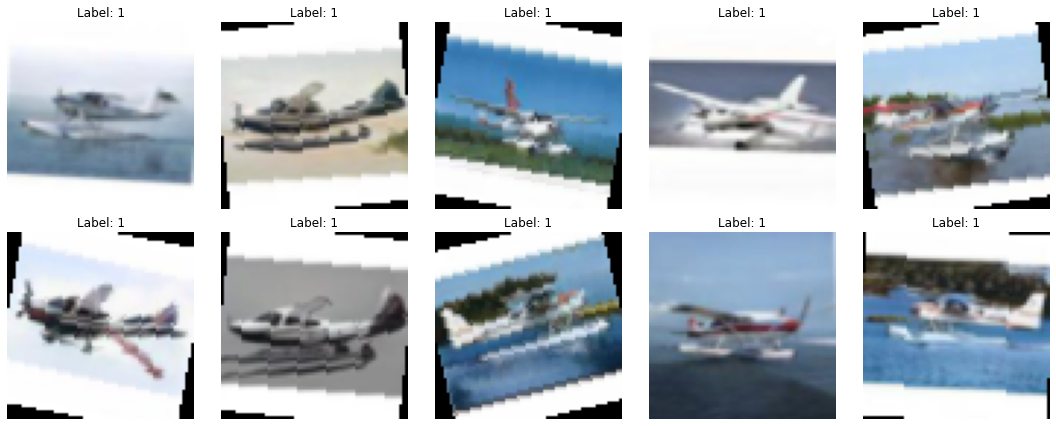

[Epoch 1/200] [Batch 0/23] [D loss: 0.6613] [G loss: 3.0143]
[Epoch 2/200] [Batch 0/23] [D loss: 0.0098] [G loss: 12.9032]
[Epoch 3/200] [Batch 0/23] [D loss: 0.1329] [G loss: 13.9517]
[Epoch 4/200] [Batch 0/23] [D loss: 0.0156] [G loss: 12.9760]
[Epoch 5/200] [Batch 0/23] [D loss: 0.0509] [G loss: 10.7478]
[Epoch 6/200] [Batch 0/23] [D loss: 0.1454] [G loss: 12.0617]
[Epoch 7/200] [Batch 0/23] [D loss: 0.0729] [G loss: 9.1601]
[Epoch 8/200] [Batch 0/23] [D loss: 0.0160] [G loss: 6.6969]
[Epoch 9/200] [Batch 0/23] [D loss: 0.0192] [G loss: 7.0613]
[Epoch 10/200] [Batch 0/23] [D loss: 0.0375] [G loss: 6.9191]
[Epoch 11/200] [Batch 0/23] [D loss: 0.2121] [G loss: 14.6475]
[Epoch 12/200] [Batch 0/23] [D loss: 0.0035] [G loss: 9.9205]
[Epoch 13/200] [Batch 0/23] [D loss: 0.0330] [G loss: 5.3981]
[Epoch 14/200] [Batch 0/23] [D loss: 0.0915] [G loss: 7.3116]
[Epoch 15/200] [Batch 0/23] [D loss: 0.0268] [G loss: 5.1837]
[Epoch 16/200] [Batch 0/23] [D loss: 0.0396] [G loss: 8.4781]
[Epoch 17/2

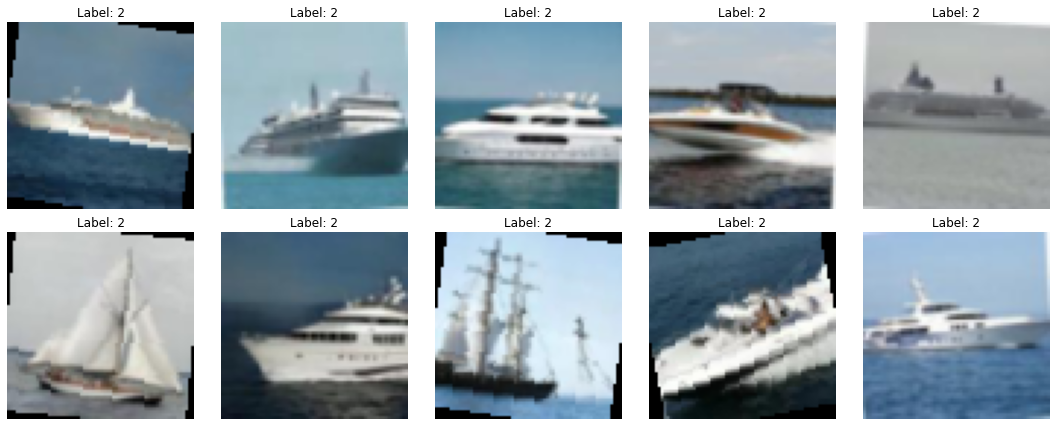

[Epoch 1/200] [Batch 0/42] [D loss: 0.6999] [G loss: 3.9903]
[Epoch 1/200] [Batch 32/42] [D loss: 0.1837] [G loss: 12.9507]
[Epoch 2/200] [Batch 0/42] [D loss: 0.0632] [G loss: 12.2535]
[Epoch 2/200] [Batch 32/42] [D loss: 0.1085] [G loss: 6.5310]
[Epoch 3/200] [Batch 0/42] [D loss: 0.3307] [G loss: 11.2129]
[Epoch 3/200] [Batch 32/42] [D loss: 0.1500] [G loss: 6.7708]
[Epoch 4/200] [Batch 0/42] [D loss: 0.0591] [G loss: 3.6354]
[Epoch 4/200] [Batch 32/42] [D loss: 0.0311] [G loss: 4.5660]
[Epoch 5/200] [Batch 0/42] [D loss: 0.0775] [G loss: 5.3895]
[Epoch 5/200] [Batch 32/42] [D loss: 0.1204] [G loss: 3.5906]
[Epoch 6/200] [Batch 0/42] [D loss: 0.0532] [G loss: 4.7426]
[Epoch 6/200] [Batch 32/42] [D loss: 0.0903] [G loss: 6.2196]
[Epoch 7/200] [Batch 0/42] [D loss: 0.0965] [G loss: 11.0798]
[Epoch 7/200] [Batch 32/42] [D loss: 0.0743] [G loss: 4.4418]
[Epoch 8/200] [Batch 0/42] [D loss: 0.1194] [G loss: 3.3405]
[Epoch 8/200] [Batch 32/42] [D loss: 0.1173] [G loss: 4.5889]
[Epoch 9/200

In [ ]:
##Train
for class_name in classes:
    # initialize hyperParameters
    noise_size = 100      
    latent_dim = 100
    input_size = 64
    batch_size = 16          
    num_epochs = 200         
    learning_rate = 0.0002
    
    # Generator와 Discriminator 초기화
    generator = Generator().to(DEVICE)
    generator.apply(weights_init)

    discriminator = Discriminator().to(DEVICE)

    # 손실 함수와 최적화 알고리즘
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    save_path = make_synthesize_img(class_name)
    train_loader = make_dataset(class_name)
    # 샘플 확인
    show_samples_from_loader(train_loader, num_samples=10, cols=5)
    
    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(train_loader):
            real_imgs = real_imgs.to(DEVICE)
            batch_size = real_imgs.size(0)

            valid = torch.ones((batch_size, 1, 1, 1), device=DEVICE)
            fake = torch.zeros((batch_size, 1, 1, 1), device=DEVICE)

            # 1. Discriminator 학습
            optimizer_D.zero_grad()

            # 진짜 이미지에 대한 손실
            real_loss = criterion(discriminator(real_imgs), valid)

            # 가짜 이미지에 대한 손실
            z = torch.randn(batch_size, noise_size, 1, 1, device=DEVICE)
            fake_imgs = generator(z)
            fake_loss = criterion(discriminator(fake_imgs.detach()), fake)  # detach() 사용

            # Discriminator 총 손실
            loss_D = (real_loss + fake_loss) / 2
            loss_D.backward()
            optimizer_D.step()

            # 2. Generator 학습
            optimizer_G.zero_grad()

            # Generator 손실 (Discriminator가 진짜로 판단하도록 학습)
            loss_G = criterion(discriminator(fake_imgs), valid)
            loss_G.backward(retain_graph=False)  # retain_graph=False로 기본 설정
            optimizer_G.step()

            # 진행 상태 출력
            if i % 32 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

            # Save generated images
            if i % 32 == 0:  # Save every 32 batches
                z = torch.randn(batch_size, latent_dim, 1, 1, device=DEVICE)
                gen_imgs = generator(z)
                for j in range(gen_imgs.size(0)):
                    file_name = f"{i * batch_size + j}.png"
                    file_path = os.path.join(save_path, file_name)
                    save_image(0.5 * gen_imgs[j] + 0.5, file_path)  # Unnormalize and save